# XGBoost

Ranklib is a relatively old library and doesn't have the wide spread use that XGBoost does. Ranklib is still under active development, but the fork of the project OSC created reflects an older version.

The ES-LTR plugin is designed to work with XGBoost model format. This notebook starts with the `classic` training data generated in `hello-ltr.py` and shows how you could use XGBoost instead of Ranklib to create a model and use it with the plugin.

### Input Data

Gather the data generated for our `classic` model in `hello-ltr.ipynb`. If this file doesn't exist yet, rerun that notebook!

In [1]:
import ltr.judgments as judge
df = [j for j in judge.judgments_from_file(open('data/classic-training.txt'))]
df = judge.judgments_to_dataframe(df)
df

Recognizing 1 queries in: data/classic-training.txt


,features0,uid,qid,keywords,docId,grade
0,2014.0,1_374430,1,,374430,0
1,1995.0,1_19404,1,,19404,1
2,1994.0,1_278,1,,278,1
3,2016.0,1_372058,1,,372058,0
4,1972.0,1_238,1,,238,2
...,...,...,...,...,...,...
995,2013.0,1_177699,1,,177699,0
996,2011.0,1_62835,1,,62835,0
997,2008.0,1_4944,1,,4944,1
998,1997.0,1_9404,1,,9404,1


### Libraries for xgboost-ing

Just the dependencies we need to train and visualize out model trained with XG-Boost instead of Ranklib.

In [2]:
import pandas as pd
import xgboost as xgb
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 50,150

### Set up our training Matrix

XGBoost has it's data specficiations so we need to get out features into that format to use it.


In [3]:
df = df[['grade', 'features0']]
features = df[['features0']]
labels = df[['grade']]

dmx = xgb.DMatrix(features, labels)

### Train the first XGBoost model

Using the demo parameters for our model, we will train a standard regression tree

In [4]:
param = {'max_depth':2, 'eta':1, 'silent':1}
num_round = 2

model = xgb.train(param, dmx, num_round)

[01:41:04] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




### Inspect as dataframe

Looking at the model as a dataframe can tell you which splits helped the most

In [5]:
model.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,features0,1990.5,0-1,0-2,0-1,1023.481080,1000.0
1,0,1,0-1,features0,1970.5,0-3,0-4,0-3,157.020874,351.0
2,0,2,0-2,features0,2010.5,0-5,0-6,0-5,154.948151,649.0
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,2.848404,187.0
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,1.490909,164.0
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,0.498724,391.0
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,-0.498069,258.0
7,1,0,1-0,features0,1950.5,1-1,1-2,1-1,30.146206,1000.0
8,1,1,1-1,Leaf,NaN,NaN,NaN,NaN,0.642152,68.0
9,1,2,1-2,features0,1970.5,1-3,1-4,1-3,12.615029,932.0


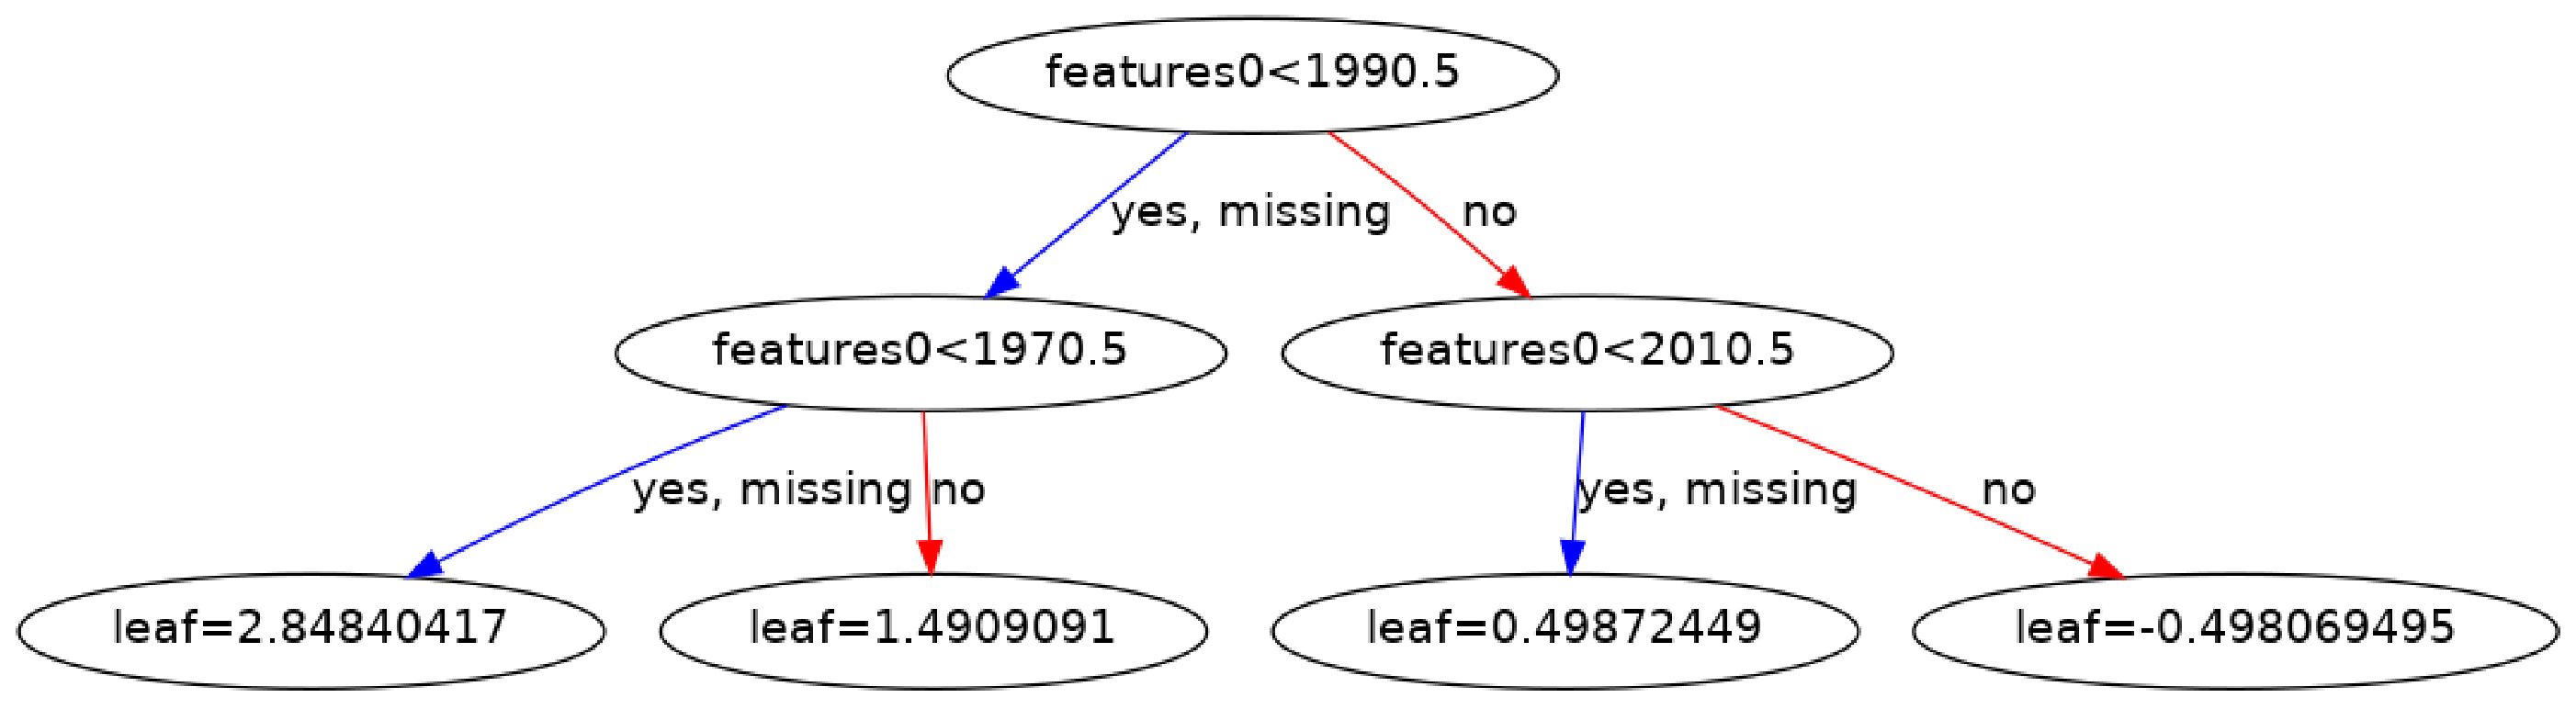

In [6]:
xgb.plot_tree(model)

### Adjust the objective for LTR

Really we don't want the regression as our objective function. In LTR we take advantage of a new pairwise loss function to find the optimal splits for a regression tree. 

This doesn't make a massive difference for the model that is generated because it is still a regression tree at the end of the day, but we are not longer using residual sqared error.

In [7]:
param2 = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'rank:pairwise'}

ranking_model = xgb.train(param2, dmx, num_round)

[01:41:21] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [8]:
ranking_model.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,features0,1990.5,0-1,0-2,0-1,392.013977,1000.000000
1,0,1,0-1,features0,1960.5,0-3,0-4,0-3,4.838547,403.500000
2,0,2,0-2,features0,2010.5,0-5,0-6,0-5,110.047058,596.500000
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.911565,146.000000
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,0.671180,257.500000
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,-0.131737,333.000000
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,-0.996219,263.500000
7,1,0,1-0,features0,2010.5,1-1,1-2,1-1,111.497101,767.250305
8,1,1,1-1,features0,1990.5,1-3,1-4,1-3,41.121555,579.572693
9,1,2,1-2,Leaf,NaN,NaN,NaN,NaN,-0.667830,187.677628


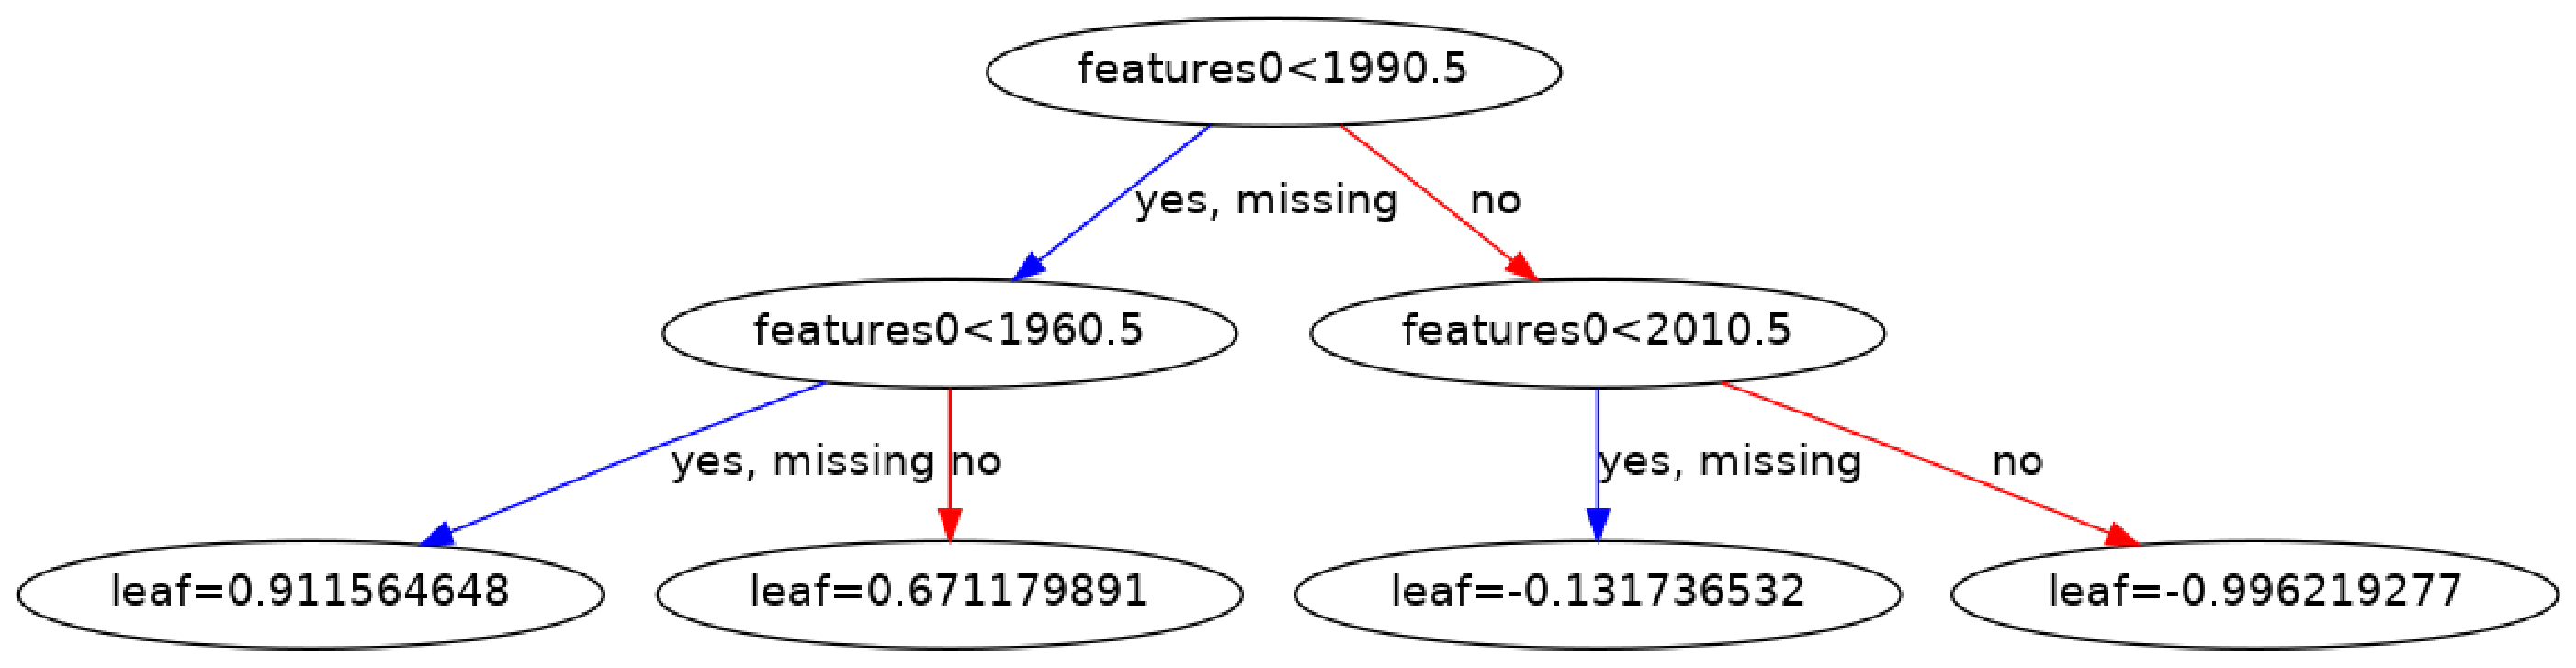

In [9]:
xgb.plot_tree(ranking_model)

### Uploading an XGBoost model to the plugin

Since the model can be represented with JSON, the plugin can parse it. But we need to make sure the plugin gets the proper feature value names in order for it to parse properly.

These are supplied via a mapping `txt` file, `fmap.txt`.

The first step is to dump the model with the feature mapping to the features already stored in the plugin.

In [10]:
model_dump = ranking_model.get_dump(fmap='fmap.txt', dump_format='json')

### Massage the JSON

Manipulate the XGBoost output format to clean it up for posting to the plugin.

In [11]:
import json
clean_model = []
for line in model_dump:
    clean_model.append(json.loads(line))

### Post it to the plugin

Still referencing the index and feature set the model will be associated with.

In [12]:
import ltr.client as client
client = client.ElasticClient()

client.submit_xgboost_model('release', 'tmdb', 'xgb', clean_model)

Delete model xgb: 404
Created Model xgb [Status: 201]


### Confirm it works

In [13]:
from ltr.release_date_plot import search
search(client, 'batman', 'xgb')

[{'id': '93560',
  'title': 'Batman and Robin',
  'overview': 'This 15-chapter serial pits Batman and Robin against The Wizard, who uses a device that allows him to control machinery to hold the city hostage.',
  'tagline': '',
  'directors': ['Spencer Gordon Bennet'],
  'cast': 'Robert Lowery Johnny Duncan Lyle Talbot Jane Adams Ralph Graves Don C. Harvey William Fawcett Leonard Penn Rick Vallin Michael Whalen Greg McClure House Peters Jr.',
  'genres': ['Action', 'Science Fiction', 'Thriller'],
  'release_date': '1949-05-26',
  'release_year': '1949',
  'poster_path': 'https://image.tmdb.org/t/p/w185/mhlVDSkxiyVqHBK8bqwfgK2v3e.jpg',
  'vote_average': 6.2,
  'vote_count': 5,
  'score': 2.3841898},
 {'id': '125249',
  'title': 'Batman',
  'overview': "Japanese spymaster Prince Daka operates a covert espionage organization located in Metropolis' now-deserted Little Tokyo which turns American scientists into pliable zombies.",
  'tagline': 'A HUNDRED TIMES MORE THRILLING ON THE SCREEN!',

### Compare it to the classic Ranklib model

In [14]:
from ltr.release_date_plot import plot
plot(client, "batman", models = ['classic', 'xgb'])